In [1]:
!pip install --no-cache-dir -q git+https://github.com/LosVolterrosHermanos/Experimental.git@everettk/moe_plrf

  Preparing metadata (setup.py) ... done


In [2]:
# MoE PLRF: Stochastic vs ODE Comparison
"""
This notebook compares stochastic training of Mixture of Experts PLRF models
with theoretical ODE predictions.
"""

#@title Setup and Imports
import jax
import jax.numpy as jnp
import jax.random as random
import optax
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from typing import NamedTuple, Callable, Dict, List
import numpy as np

from power_law_rf.optimizers import powerlaw_schedule, dana_optimizer

# Import MoE PLRF implementations from installed package
from power_law_rf.moe_plrf.moe_plrf import (
    TwoExpertPLRF,
    MoEPLRFTrainer,
    MixtureOfExpertsPLRF
)
from power_law_rf.moe_plrf.moe_plrf_ode import (
    ode_moe_dana_log_implicit,
    MoEODEInputs
)
from power_law_rf.ode import DanaHparams
import power_law_rf.deterministic_equivalent as theory

# Set random seed
key = random.PRNGKey(42)

In [4]:
#@title Global Parameters
# Model parameters
ALPHA = 1.0
BETA_LIST = [0.5, 0.8, 1.1, 1.4]
# BETA_LIST = [0.8]
# BETA = 0.8
V = 2000  # Hidden dimension
D = 500   # Parameter dimension

# MoE parameters
M = 12  # Number of experts for general MoE
P = 0.1  # Probability for expert 2 in two-expert case
ZETA = 1.0  # Power-law exponent for expert selection

# Training parameters
# BATCH_SIZE = 32
STEPS = 10000
DT = 1e-3  # ODE time step

# Learning rate schedules
BASE_LR = 0.01
MOMENTUM = 0.9

G2_SCALE = 0.5
G3_IV = 0.2
BATCH_SIZE = 1

def get_traceK(alpha, v):
  x_grid = jnp.arange(1, v+1).reshape(1, v)
  population_eigs = x_grid ** -alpha
  population_trace = jnp.sum(population_eigs**2)
  return population_trace

def get_sgd_hparams(g2_scale, batch_size, traceK):
  learning_rate = g2_scale * jnp.minimum(1.0, jnp.float32(batch_size) / traceK)
  dana_params_sgd = DanaHparams(
    g1=lambda t: 0.0,  # No momentum accumulation
    g2=lambda t: learning_rate,  # Direct gradient update
    g3=lambda t: 0.0,  # No momentum contribution
    delta=lambda t: 1.0  # Full momentum decay
  )
  return dana_params_sgd

def get_dana_constant_hparams(alpha, beta, d, batch_size, g2_scale, g3_iv, traceK):
  learning_rate = g2_scale * jnp.minimum(1.0, jnp.float32(batch_size) / traceK)
  g1 = powerlaw_schedule(1.0, 0.0, 0.0, 1.0)
  g2 = powerlaw_schedule(learning_rate, 0.0, 0.0, 1.0)
  g3 = powerlaw_schedule(g3_iv * batch_size / d, 0.0, 0.0, 1.0)
  delta = powerlaw_schedule(4.0+2*(alpha+beta)/(2*alpha), 0.0, -1.0, 1.0)
  return DanaHparams(g1=g1, g2=g2, g3=g3, delta=delta)

def get_dana_decaying_hparams(alpha, beta, d, batch_size, g2_scale, g3_iv, traceK):
  kappa_b = jnp.log(batch_size) / jnp.log(d)  # exponent for batch wrt d
  learning_rate = g2_scale * jnp.minimum(1.0, jnp.float32(batch_size) / traceK)
  g1 = powerlaw_schedule(1.0, 0.0, 0.0, 1.0)
  g2 = powerlaw_schedule(learning_rate, 0.0, 0.0, 1.0)
  g3 = powerlaw_schedule(g3_iv, 0.0, -(1.0 - kappa_b) / (2 * alpha), 1.0)
  # delta = powerlaw_schedule(4.0+2*(alpha+beta)/(2*alpha), 0.0, -1.0, 1.0)
  delta = powerlaw_schedule(1.0, 0.0, -1.0, 4.0+2*(alpha+beta)/(2*alpha))
  return DanaHparams(g1=g1, g2=g2, g3=g3, delta=delta)

traceK = get_traceK(ALPHA, V)
# Examples:
# sgd_hparams = get_sgd_hparams(G2_SCALE, BATCH_SIZE, traceK)
# sgd_opt = dana_optimizer(sgd_hparams.g1, sgd_hparams.g2, sgd_hparams.g3, sgd_hparams.delta)
# dana_constant_hparams = get_dana_constant_hparams(ALPHA, BETA, D, BATCH_SIZE, G2_SCALE, G3_IV, traceK)
# dana_constant_opt = dana_optimizer(dana_constant_hparams.g1, dana_constant_hparams.g2, dana_constant_hparams.g3, dana_constant_hparams.delta)
# dana_decaying_hparams = get_dana_decaying_hparams(ALPHA, BETA, D, BATCH_SIZE, G2_SCALE, G3_IV, traceK)
# dana_decaying_opt = dana_optimizer(dana_decaying_hparams.g1, dana_decaying_hparams.g2, dana_decaying_hparams.g3, dana_decaying_hparams.delta)

In [8]:
#@title Part 1: Two-Expert Comparison (SGD vs DANA-decaying)
"""
First, we'll compare SGD and DANA-decaying on a two-expert PLRF model
to validate the theoretical predictions about timescale separation.
"""

print("="*60)
print("Two-Expert PLRF: SGD vs DANA-decaying Comparison")
print("="*60)

two_expert_results = []

for beta in BETA_LIST:
    print(f"\nRunning experiments for β = {beta}")

    # Create two-expert model
    key, model_key = random.split(key)
    model = TwoExpertPLRF(
        alpha=ALPHA,
        beta=beta,
        v=V,
        d=D,
        p=P,
        key=model_key
    )

    print(f"  Expert probabilities: p₁ = {1-P:.2f}, p₂ = {P:.2f}")
    print(f"  Optimal risk: {model.optimal_risk():.6f}")

    sgd_hparams = get_sgd_hparams(G2_SCALE, BATCH_SIZE, traceK)
    sgd_opt = dana_optimizer(sgd_hparams.g1, sgd_hparams.g2, sgd_hparams.g3, sgd_hparams.delta)
    dana_constant_hparams = get_dana_constant_hparams(ALPHA, beta, D, BATCH_SIZE, G2_SCALE, G3_IV, traceK)
    dana_constant_opt = dana_optimizer(dana_constant_hparams.g1, dana_constant_hparams.g2, dana_constant_hparams.g3, dana_constant_hparams.delta)
    dana_decaying_hparams = get_dana_decaying_hparams(ALPHA, beta, D, BATCH_SIZE, G2_SCALE, G3_IV, traceK)
    dana_decaying_opt = dana_optimizer(dana_decaying_hparams.g1, dana_decaying_hparams.g2, dana_decaying_hparams.g3, dana_decaying_hparams.delta)

    # SGD experiment
    sgd_trainer = MoEPLRFTrainer(model, sgd_opt)

    key, train_key = random.split(key)
    sgd_results = sgd_trainer.train(
        train_key,
        num_steps=STEPS,
        batch_size=BATCH_SIZE,
        track_per_expert_loss=True
    )

    # DANA experiment
    dana_decaying_trainer = MoEPLRFTrainer(model, dana_decaying_opt)

    key, train_key = random.split(key)
    dana_decaying_results = dana_decaying_trainer.train(
        train_key,
        num_steps=STEPS,
        batch_size=BATCH_SIZE,
        track_per_expert_loss=True
    )

    two_expert_results.append({
        'beta': beta,
        'model': model,
        'sgd': sgd_results,
        'dana_decaying': dana_decaying_results,
    })

Two-Expert PLRF: SGD vs DANA-decaying Comparison

Running experiments for β = 0.5
  Expert probabilities: p₁ = 0.90, p₂ = 0.10
  Optimal risk: 0.000029


100%|██████████| 10000/10000 [00:13<00:00, 744.94it/s]



Running experiments for β = 0.8
  Expert probabilities: p₁ = 0.90, p₂ = 0.10
  Optimal risk: 0.000009


100%|██████████| 10000/10000 [00:13<00:00, 745.84it/s]



Running experiments for β = 1.1
  Expert probabilities: p₁ = 0.90, p₂ = 0.10
  Optimal risk: 0.000005


100%|██████████| 10000/10000 [00:12<00:00, 799.75it/s]



Running experiments for β = 1.4
  Expert probabilities: p₁ = 0.90, p₂ = 0.10
  Optimal risk: 0.000005


100%|██████████| 10000/10000 [00:12<00:00, 784.39it/s]


In [7]:
beta = BETA_LIST[0]
fake_eigs, rho_init = theory.theory_rhos(ALPHA, beta, D)
sigma_init = jnp.zeros_like(rho_init)
chi_init = jnp.zeros_like(rho_init)

# Compute theoretical limit loss
risk_infty_theory = theory.theory_limit_loss(ALPHA, beta, V, D)

# Create MoE ODE inputs
expert_probs = jnp.array([1-P, P])
ode_inputs = MoEODEInputs(
    eigs_K=fake_eigs,
    rho_init=rho_init,
    chi_init=chi_init,
    sigma_init=sigma_init,
    risk_infinity=risk_infty_theory,
    expert_probs=expert_probs
)

sgd_hparams = get_sgd_hparams(G2_SCALE, BATCH_SIZE, traceK)

# Run ODE for SGD
ode_times_sgd, expert_risks_sgd, total_risk_sgd = ode_moe_dana_log_implicit(
    ode_inputs,
    sgd_hparams,
    batch=BATCH_SIZE,
    D=D,
    m=2,
    t_max=STEPS,
    dt=DT,
    approximate=True
)

In [9]:
#@title Part 2: ODE Predictions for Two-Expert Model
"""
Now we'll generate ODE predictions for the same two-expert configurations.
"""

print("\n" + "="*60)
print("Computing ODE Predictions")
print("="*60)

two_expert_ode_results = []

for result in two_expert_results:
    beta = result['beta']
    model = result['model']

    print(f"\nComputing ODE for β = {beta}")

    # Get theoretical eigenvalues and initial rhos
    fake_eigs, rho_init = theory.theory_rhos(ALPHA, beta, D)
    sigma_init = jnp.zeros_like(rho_init)
    chi_init = jnp.zeros_like(rho_init)

    # Compute theoretical limit loss
    risk_infty_theory = theory.theory_limit_loss(ALPHA, beta, V, D)

    # Create MoE ODE inputs
    expert_probs = jnp.array([1-P, P])
    ode_inputs = MoEODEInputs(
        eigs_K=fake_eigs,
        rho_init=rho_init,
        chi_init=chi_init,
        sigma_init=sigma_init,
        risk_infinity=risk_infty_theory,
        expert_probs=expert_probs
    )

    sgd_hparams = get_sgd_hparams(G2_SCALE, BATCH_SIZE, traceK)
    dana_constant_hparams = get_dana_constant_hparams(ALPHA, beta, D, BATCH_SIZE, G2_SCALE, G3_IV, traceK)
    dana_decaying_hparams = get_dana_decaying_hparams(ALPHA, beta, D, BATCH_SIZE, G2_SCALE, G3_IV, traceK)

    # Run ODE for SGD
    ode_times_sgd, expert_risks_sgd, total_risk_sgd = ode_moe_dana_log_implicit(
        ode_inputs,
        sgd_hparams,
        batch=BATCH_SIZE,
        D=D,
        m=2,
        t_max=STEPS,
        dt=DT,
        approximate=True
    )

    # Run ODE for DANA decaying
    ode_times_dana_decaying, expert_risks_dana_decaying, total_risk_dana_decaying = ode_moe_dana_log_implicit(
        ode_inputs,
        dana_decaying_hparams,
        batch=BATCH_SIZE,
        D=D,
        m=2,
        t_max=STEPS,
        dt=DT,
        approximate=True
    )

    two_expert_ode_results.append({
        'beta': beta,
        'sgd': {
            'times': ode_times_sgd,
            'expert_risks': expert_risks_sgd / 2,  # Convert to actual risk
            'total_risk': total_risk_sgd / 2
        },
        'dana_decaying': {
            'times': ode_times_dana_decaying,
            'expert_risks': expert_risks_dana_decaying / 2,
            'total_risk': total_risk_dana_decaying / 2
        }
    })


Computing ODE Predictions

Computing ODE for β = 0.5

Computing ODE for β = 0.8

Computing ODE for β = 1.1

Computing ODE for β = 1.4


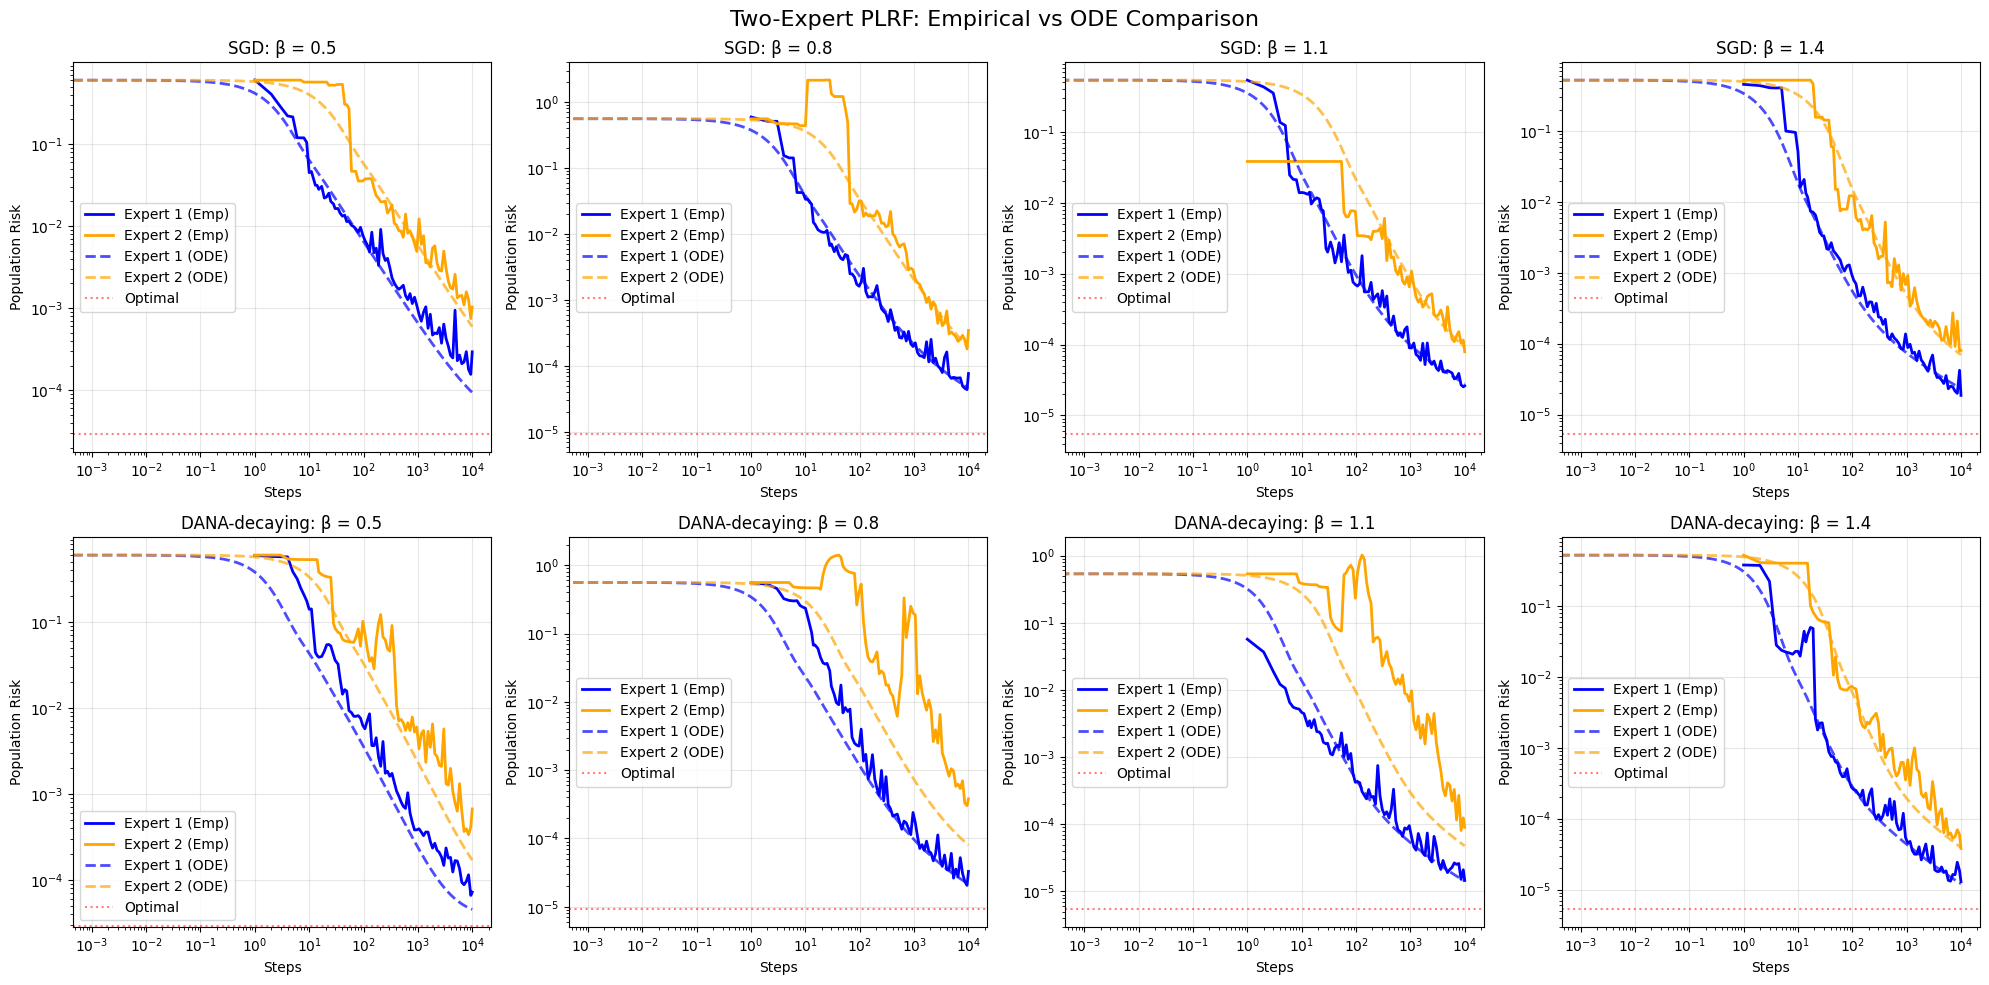

In [10]:
#@title Part 3: Visualization - Two Expert Results
"""
Create comparison plots for two-expert results.
"""

fig, axes = plt.subplots(2, len(BETA_LIST), figsize=(5*len(BETA_LIST), 10))
if len(BETA_LIST) == 1:
    axes = axes.reshape(2, 1)

for idx, (emp_result, ode_result) in enumerate(zip(two_expert_results, two_expert_ode_results)):
    beta = emp_result['beta']

    # Top row: SGD comparison
    ax = axes[0, idx]

    # Empirical SGD
    timestamps = emp_result['sgd']['timestamps']
    ax.loglog(timestamps[1:], emp_result['sgd']['per_expert_losses'][0][1:],
              'b-', label='Expert 1 (Emp)', linewidth=2)
    ax.loglog(timestamps[1:], emp_result['sgd']['per_expert_losses'][1][1:],
              'orange', label='Expert 2 (Emp)', linewidth=2)

    # ODE SGD
    ode_times = ode_result['sgd']['times']
    ax.loglog(ode_times, ode_result['sgd']['expert_risks'][:, 0],
              'b--', label='Expert 1 (ODE)', linewidth=2, alpha=0.7)
    ax.loglog(ode_times, ode_result['sgd']['expert_risks'][:, 1],
              'orange', linestyle='--', label='Expert 2 (ODE)', linewidth=2, alpha=0.7)

    ax.axhline(y=emp_result['model'].optimal_risk(), color='red',
               linestyle=':', label='Optimal', alpha=0.5)
    ax.set_xlabel('Steps')
    ax.set_ylabel('Population Risk')
    ax.set_title(f'SGD: β = {beta}')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Bottom row: DANA decaying comparison
    ax = axes[1, idx]

    # Empirical DANA decaying
    ax.loglog(timestamps[1:], emp_result['dana_decaying']['per_expert_losses'][0][1:],
              'b-', label='Expert 1 (Emp)', linewidth=2)
    ax.loglog(timestamps[1:], emp_result['dana_decaying']['per_expert_losses'][1][1:],
              'orange', label='Expert 2 (Emp)', linewidth=2)

    # ODE DANA decaying
    ax.loglog(ode_times, ode_result['dana_decaying']['expert_risks'][:, 0],
              'b--', label='Expert 1 (ODE)', linewidth=2, alpha=0.7)
    ax.loglog(ode_times, ode_result['dana_decaying']['expert_risks'][:, 1],
              'orange', linestyle='--', label='Expert 2 (ODE)', linewidth=2, alpha=0.7)

    ax.axhline(y=emp_result['model'].optimal_risk(), color='red',
               linestyle=':', label='Optimal', alpha=0.5)
    ax.set_xlabel('Steps')
    ax.set_ylabel('Population Risk')
    ax.set_title(f'DANA-decaying: β = {beta}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Two-Expert PLRF: Empirical vs ODE Comparison', fontsize=16)
plt.tight_layout()
plt.show()

In [11]:
#@title Part 4: General MoE with Power-Law Expert Selection
"""
Test the general MoE model with power-law expert selection using SGD and DANA-decaying.
"""

print("\n" + "="*60)
print(f"General MoE PLRF: {M} Experts with Power-Law Selection")
print("="*60)

moe_results = []

for beta in BETA_LIST:
    print(f"\nRunning MoE experiments for β = {beta}")

    # Create MoE model
    key, model_key = random.split(key)
    model = MixtureOfExpertsPLRF(
        alpha=ALPHA,
        beta=beta,
        v=V,
        d=D,
        m=M,
        zeta=ZETA,
        key=model_key
    )

    print(f"  Expert probabilities: {model.expert_probs}")
    print(f"  Optimal risk: {model.population_risk(model.optimal_params_per_expert()):.6f}")

    # Create hyperparameters using the same helper functions
    sgd_hparams = get_sgd_hparams(G2_SCALE, BATCH_SIZE, traceK)
    sgd_opt = dana_optimizer(sgd_hparams.g1, sgd_hparams.g2, sgd_hparams.g3, sgd_hparams.delta)
    dana_decaying_hparams = get_dana_decaying_hparams(ALPHA, beta, D, BATCH_SIZE, G2_SCALE, G3_IV, traceK)
    dana_decaying_opt = dana_optimizer(dana_decaying_hparams.g1, dana_decaying_hparams.g2, dana_decaying_hparams.g3, dana_decaying_hparams.delta)

    # SGD experiment
    sgd_trainer = MoEPLRFTrainer(model, sgd_opt)
    key, train_key = random.split(key)
    sgd_results = sgd_trainer.train(
        train_key,
        num_steps=STEPS,
        batch_size=BATCH_SIZE,
        track_per_expert_loss=True
    )

    # DANA-decaying experiment
    dana_decaying_trainer = MoEPLRFTrainer(model, dana_decaying_opt)
    key, train_key = random.split(key)
    dana_decaying_results = dana_decaying_trainer.train(
        train_key,
        num_steps=STEPS,
        batch_size=BATCH_SIZE,
        track_per_expert_loss=True
    )

    moe_results.append({
        'beta': beta,
        'model': model,
        'sgd': sgd_results,
        'dana_decaying': dana_decaying_results
    })




General MoE PLRF: 12 Experts with Power-Law Selection

Running MoE experiments for β = 0.5
  Expert probabilities: [0.32224688 0.16112344 0.10741563 0.08056172 0.06444938 0.05370782
 0.04603527 0.04028086 0.03580521 0.03222469 0.02929517 0.02685391]
  Optimal risk: 0.000026


100%|██████████| 10000/10000 [00:14<00:00, 704.47it/s]



Running MoE experiments for β = 0.8
  Expert probabilities: [0.32224688 0.16112344 0.10741563 0.08056172 0.06444938 0.05370782
 0.04603527 0.04028086 0.03580521 0.03222469 0.02929517 0.02685391]
  Optimal risk: 0.000010


100%|██████████| 10000/10000 [00:14<00:00, 671.62it/s]



Running MoE experiments for β = 1.1
  Expert probabilities: [0.32224688 0.16112344 0.10741563 0.08056172 0.06444938 0.05370782
 0.04603527 0.04028086 0.03580521 0.03222469 0.02929517 0.02685391]
  Optimal risk: 0.000005


100%|██████████| 10000/10000 [00:15<00:00, 632.99it/s]



Running MoE experiments for β = 1.4
  Expert probabilities: [0.32224688 0.16112344 0.10741563 0.08056172 0.06444938 0.05370782
 0.04603527 0.04028086 0.03580521 0.03222469 0.02929517 0.02685391]
  Optimal risk: 0.000005


100%|██████████| 10000/10000 [00:14<00:00, 700.09it/s]


In [12]:
#@title Part 5: ODE Predictions for General MoE
"""
Compute ODE predictions for the general MoE model using SGD and DANA-decaying.
"""

print("\n" + "="*60)
print("Computing MoE ODE Predictions")
print("="*60)

moe_ode_results = []

for moe_result in moe_results:
    beta = moe_result['beta']
    model = moe_result['model']

    print(f"\nComputing MoE ODE for β = {beta}")

    # Get theoretical initialization
    fake_eigs, rho_init = theory.theory_rhos(ALPHA, beta, D)
    sigma_init = jnp.zeros_like(rho_init)
    chi_init = jnp.zeros_like(rho_init)
    risk_infty_theory = theory.theory_limit_loss(ALPHA, beta, V, D)

    # Create ODE inputs
    ode_inputs = MoEODEInputs(
        eigs_K=fake_eigs,
        rho_init=rho_init,
        chi_init=chi_init,
        sigma_init=sigma_init,
        risk_infinity=risk_infty_theory,
        expert_probs=model.expert_probs
    )

    # Use the same hyperparameters as in the empirical experiments
    sgd_hparams = get_sgd_hparams(G2_SCALE, BATCH_SIZE, traceK)
    dana_decaying_hparams = get_dana_decaying_hparams(ALPHA, beta, D, BATCH_SIZE, G2_SCALE, G3_IV, traceK)

    # Run ODE for SGD
    ode_times_sgd, expert_risks_sgd, total_risk_sgd = ode_moe_dana_log_implicit(
        ode_inputs,
        sgd_hparams,
        batch=BATCH_SIZE,
        D=D,
        m=M,
        t_max=STEPS,
        dt=DT,
        approximate=True
    )

    # Run ODE for DANA-decaying
    ode_times_dana_decaying, expert_risks_dana_decaying, total_risk_dana_decaying = ode_moe_dana_log_implicit(
        ode_inputs,
        dana_decaying_hparams,
        batch=BATCH_SIZE,
        D=D,
        m=M,
        t_max=STEPS,
        dt=DT,
        approximate=True
    )

    moe_ode_results.append({
        'beta': beta,
        'sgd': {
            'times': ode_times_sgd,
            'expert_risks': expert_risks_sgd / 2,  # Convert to actual risk
            'total_risk': total_risk_sgd / 2
        },
        'dana_decaying': {
            'times': ode_times_dana_decaying,
            'expert_risks': expert_risks_dana_decaying / 2,
            'total_risk': total_risk_dana_decaying / 2
        }
    })




Computing MoE ODE Predictions

Computing MoE ODE for β = 0.5

Computing MoE ODE for β = 0.8

Computing MoE ODE for β = 1.1

Computing MoE ODE for β = 1.4


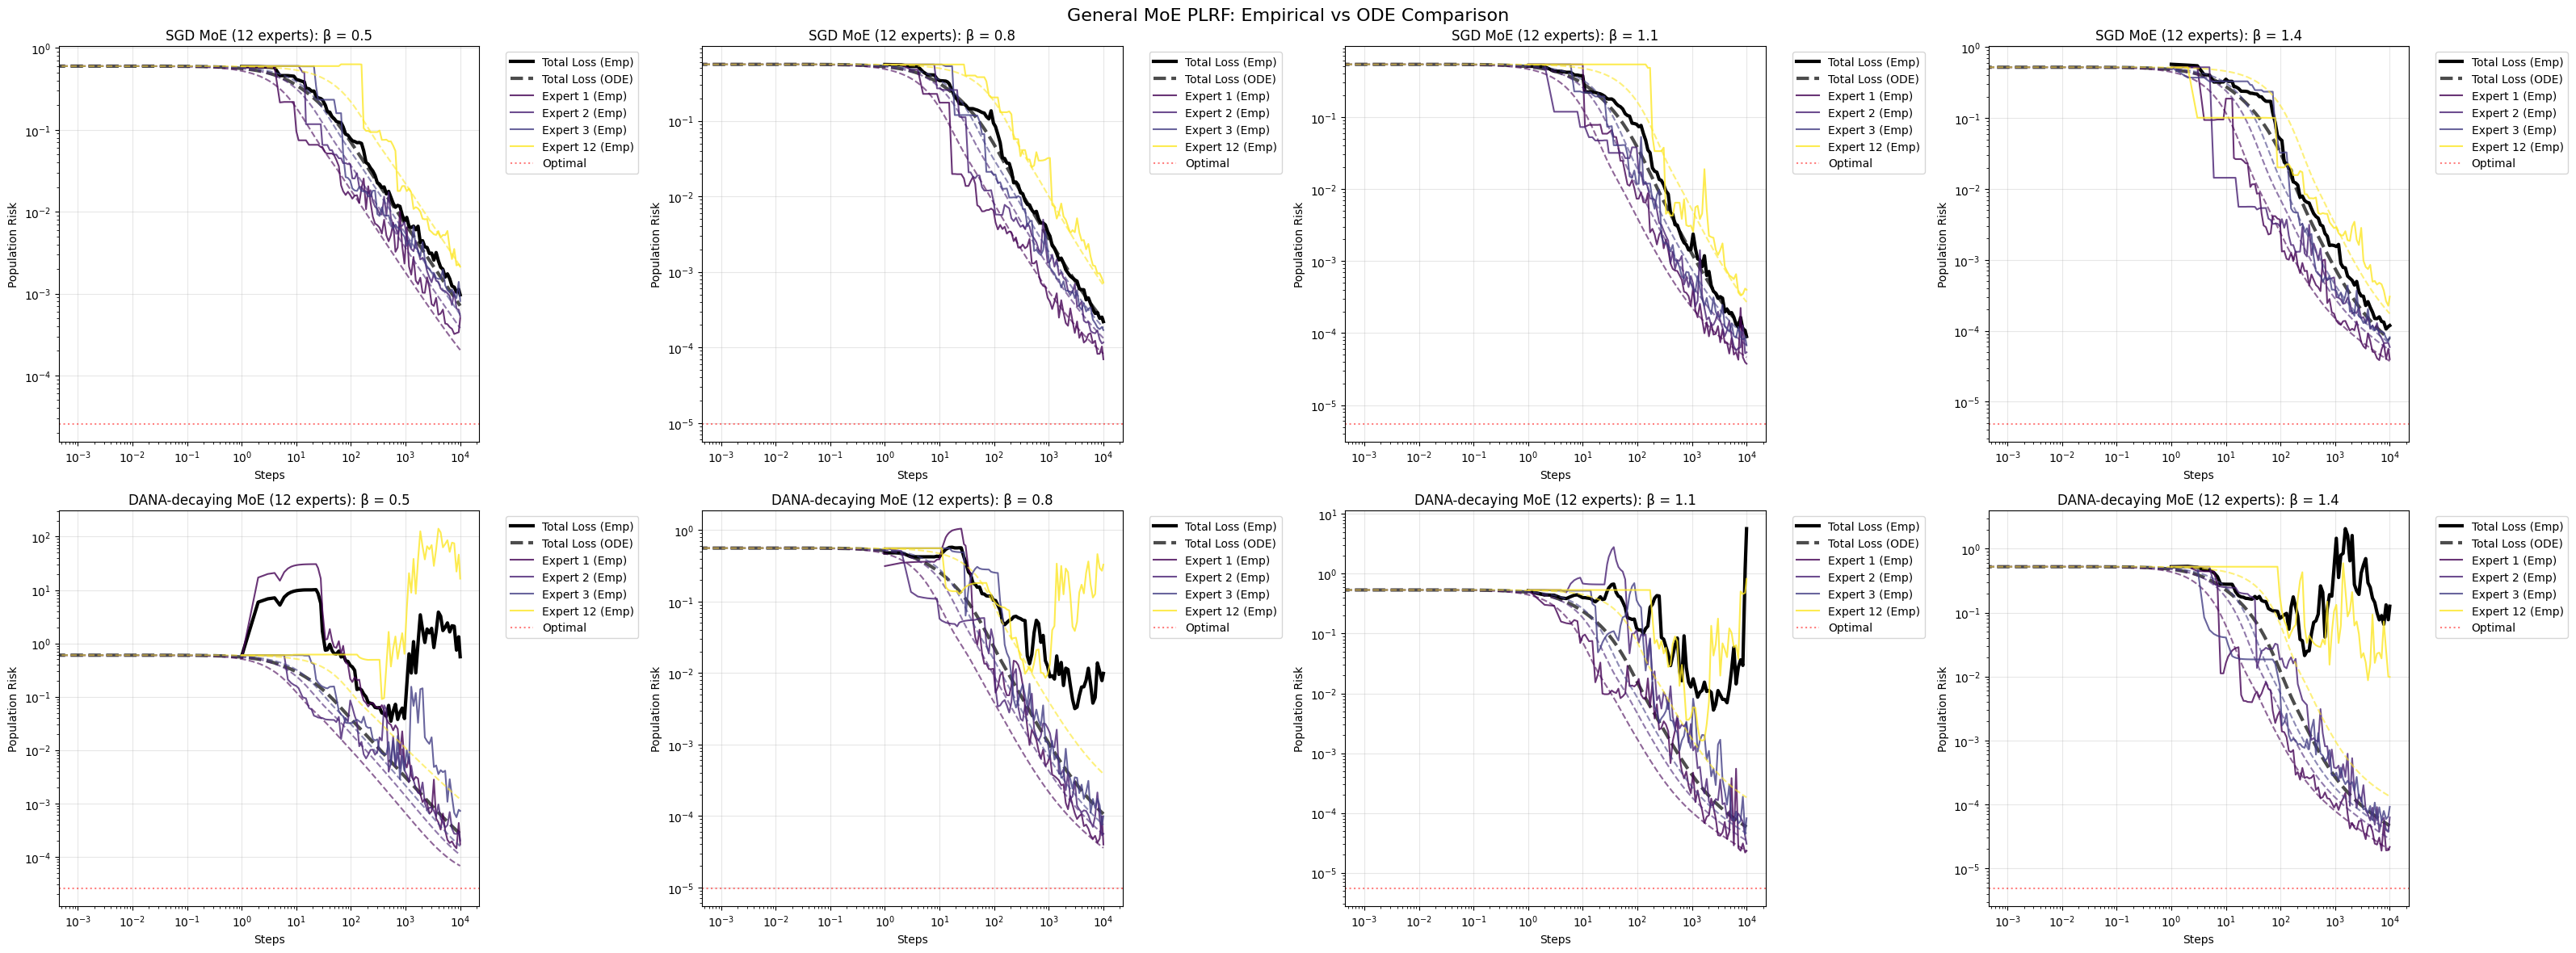

In [13]:
#@title Part 6: Visualization - General MoE Results
"""
Visualize general MoE results with ODE comparison for both SGD and DANA-decaying.
"""

fig, axes = plt.subplots(2, len(moe_results), figsize=(8*len(moe_results), 12))
if len(moe_results) == 1:
    axes = axes.reshape(2, 1)

for idx, (emp_result, ode_result) in enumerate(zip(moe_results, moe_ode_results)):
    beta = emp_result['beta']

    # Top row: SGD comparison
    ax = axes[0, idx]

    # Plot total loss comparison
    timestamps = emp_result['sgd']['timestamps']
    ax.loglog(timestamps[1:], emp_result['sgd']['losses'][1:],
              'k-', label='Total Loss (Emp)', linewidth=3)

    ode_times = ode_result['sgd']['times']
    ax.loglog(ode_times, ode_result['sgd']['total_risk'],
              'k--', label='Total Loss (ODE)', linewidth=3, alpha=0.7)

    # Plot per-expert losses (only show a subset for clarity)
    colors = plt.cm.viridis(np.linspace(0, 1, M))
    # Show only first 3 and last expert to avoid overcrowding
    experts_to_show = list(range(min(3, M))) + [M-1] if M > 4 else range(M)

    for i in experts_to_show:
        ax.loglog(timestamps[1:], emp_result['sgd']['per_expert_losses'][i][1:],
                  color=colors[i], label=f'Expert {i+1} (Emp)', linewidth=1.5, alpha=0.8)
        ax.loglog(ode_times, ode_result['sgd']['expert_risks'][:, i],
                  color=colors[i], linestyle='--', alpha=0.6, linewidth=1.5)

    ax.axhline(y=emp_result['model'].optimal_risk(), color='red',
               linestyle=':', label='Optimal', alpha=0.5)
    ax.set_xlabel('Steps')
    ax.set_ylabel('Population Risk')
    ax.set_title(f'SGD MoE ({M} experts): β = {beta}')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)

    # Bottom row: DANA-decaying comparison
    ax = axes[1, idx]

    # Plot total loss comparison
    ax.loglog(timestamps[1:], emp_result['dana_decaying']['losses'][1:],
              'k-', label='Total Loss (Emp)', linewidth=3)

    ax.loglog(ode_times, ode_result['dana_decaying']['total_risk'],
              'k--', label='Total Loss (ODE)', linewidth=3, alpha=0.7)

    # Plot per-expert losses
    for i in experts_to_show:
        ax.loglog(timestamps[1:], emp_result['dana_decaying']['per_expert_losses'][i][1:],
                  color=colors[i], label=f'Expert {i+1} (Emp)', linewidth=1.5, alpha=0.8)
        ax.loglog(ode_times, ode_result['dana_decaying']['expert_risks'][:, i],
                  color=colors[i], linestyle='--', alpha=0.6, linewidth=1.5)

    ax.axhline(y=emp_result['model'].optimal_risk(), color='red',
               linestyle=':', label='Optimal', alpha=0.5)
    ax.set_xlabel('Steps')
    ax.set_ylabel('Population Risk')
    ax.set_title(f'DANA-decaying MoE ({M} experts): β = {beta}')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)

plt.suptitle(f'General MoE PLRF: Empirical vs ODE Comparison', fontsize=16)
plt.tight_layout()
plt.show()



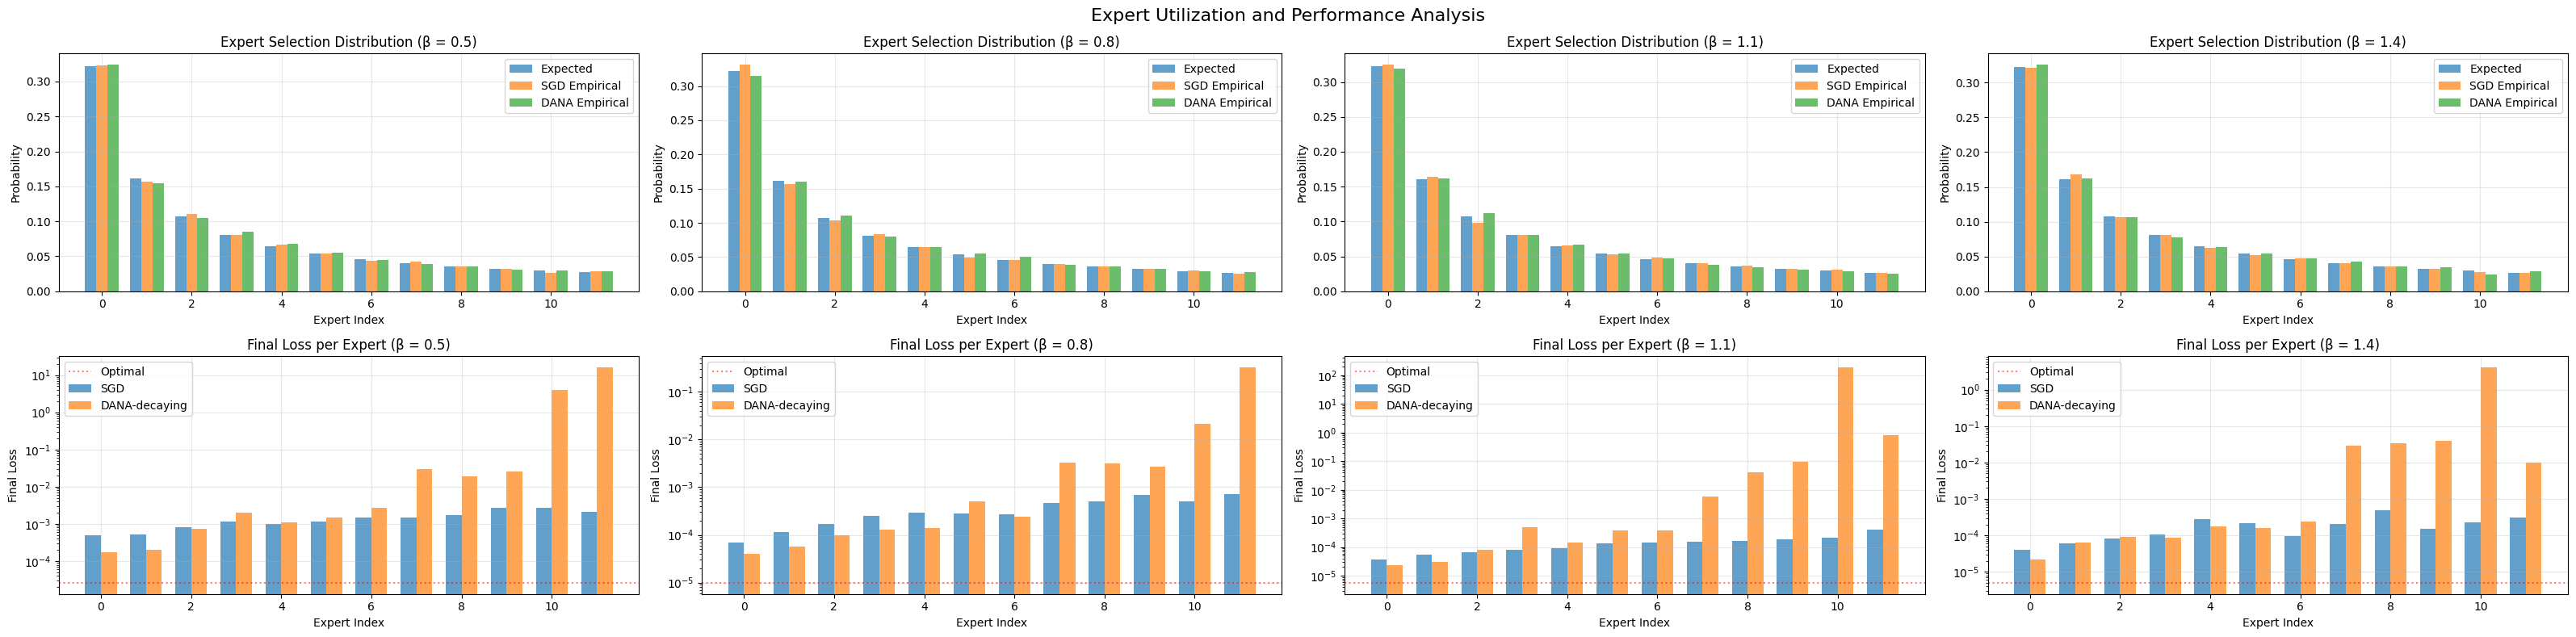


EXPERIMENT SUMMARY

Two-Expert Results:

β = 0.5:
  SGD final loss: 0.000367 (gap: 0.000338)
  DANA-decaying final loss: 0.000131 (gap: 0.000102)
  Expert 1 final (SGD): 0.000293
  Expert 2 final (SGD): 0.001031
  Expert 1 final (DANA): 0.000072
  Expert 2 final (DANA): 0.000667

β = 0.8:
  SGD final loss: 0.000104 (gap: 0.000094)
  DANA-decaying final loss: 0.000068 (gap: 0.000059)
  Expert 1 final (SGD): 0.000077
  Expert 2 final (SGD): 0.000345
  Expert 1 final (DANA): 0.000033
  Expert 2 final (DANA): 0.000380

β = 1.1:
  SGD final loss: 0.000031 (gap: 0.000026)
  DANA-decaying final loss: 0.000022 (gap: 0.000017)
  Expert 1 final (SGD): 0.000026
  Expert 2 final (SGD): 0.000079
  Expert 1 final (DANA): 0.000015
  Expert 2 final (DANA): 0.000090

β = 1.4:
  SGD final loss: 0.000025 (gap: 0.000020)
  DANA-decaying final loss: 0.000015 (gap: 0.000010)
  Expert 1 final (SGD): 0.000019
  Expert 2 final (SGD): 0.000080
  Expert 1 final (DANA): 0.000013
  Expert 2 final (DANA): 0.000038

In [14]:
#@title Part 7: Expert Utilization Analysis
"""
Analyze how different experts are utilized during training for both SGD and DANA-decaying.
"""

fig, axes = plt.subplots(2, len(moe_results), figsize=(8*len(moe_results), 8))
if len(moe_results) == 1:
    axes = axes.reshape(2, 1)

for idx, emp_result in enumerate(moe_results):
    beta = emp_result['beta']
    model = emp_result['model']

    # Top: Sample distribution comparison (SGD vs DANA-decaying)
    ax = axes[0, idx]

    sgd_empirical_probs = emp_result['sgd']['expert_sample_counts'] / np.sum(emp_result['sgd']['expert_sample_counts'])
    dana_empirical_probs = emp_result['dana_decaying']['expert_sample_counts'] / np.sum(emp_result['dana_decaying']['expert_sample_counts'])

    x = np.arange(M)
    width = 0.25
    ax.bar(x - width, model.expert_probs, width, label='Expected', alpha=0.7)
    ax.bar(x, sgd_empirical_probs, width, label='SGD Empirical', alpha=0.7)
    ax.bar(x + width, dana_empirical_probs, width, label='DANA Empirical', alpha=0.7)
    ax.set_xlabel('Expert Index')
    ax.set_ylabel('Probability')
    ax.set_title(f'Expert Selection Distribution (β = {beta})')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Bottom: Final loss per expert comparison
    ax = axes[1, idx]

    sgd_final_losses = [emp_result['sgd']['per_expert_losses'][i][-1] for i in range(M)]
    dana_final_losses = [emp_result['dana_decaying']['per_expert_losses'][i][-1] for i in range(M)]

    x = np.arange(M)
    width = 0.35
    ax.bar(x - width/2, sgd_final_losses, width, label='SGD', alpha=0.7)
    ax.bar(x + width/2, dana_final_losses, width, label='DANA-decaying', alpha=0.7)
    ax.axhline(y=model.optimal_risk(), color='red', linestyle=':', label='Optimal', alpha=0.5)
    ax.set_xlabel('Expert Index')
    ax.set_ylabel('Final Loss')
    ax.set_title(f'Final Loss per Expert (β = {beta})')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')

plt.suptitle('Expert Utilization and Performance Analysis', fontsize=16)
plt.tight_layout()
plt.show()

#@title Summary
print("\n" + "="*60)
print("EXPERIMENT SUMMARY")
print("="*60)

print("\nTwo-Expert Results:")
for emp_result in two_expert_results:
    beta = emp_result['beta']
    final_sgd = emp_result['sgd']['losses'][-1]
    final_dana = emp_result['dana_decaying']['losses'][-1]
    optimal = emp_result['model'].optimal_risk()

    print(f"\nβ = {beta}:")
    print(f"  SGD final loss: {final_sgd:.6f} (gap: {final_sgd - optimal:.6f})")
    print(f"  DANA-decaying final loss: {final_dana:.6f} (gap: {final_dana - optimal:.6f})")
    print(f"  Expert 1 final (SGD): {emp_result['sgd']['per_expert_losses'][0][-1]:.6f}")
    print(f"  Expert 2 final (SGD): {emp_result['sgd']['per_expert_losses'][1][-1]:.6f}")
    print(f"  Expert 1 final (DANA): {emp_result['dana_decaying']['per_expert_losses'][0][-1]:.6f}")
    print(f"  Expert 2 final (DANA): {emp_result['dana_decaying']['per_expert_losses'][1][-1]:.6f}")

print("\n\nGeneral MoE Results:")
for emp_result in moe_results:
    beta = emp_result['beta']
    final_sgd = emp_result['sgd']['losses'][-1]
    final_dana = emp_result['dana_decaying']['losses'][-1]
    optimal = emp_result['model'].optimal_risk()

    print(f"\nβ = {beta}:")
    print(f"  SGD final loss: {final_sgd:.6f} (gap: {final_sgd - optimal:.6f})")
    print(f"  DANA-decaying final loss: {final_dana:.6f} (gap: {final_dana - optimal:.6f})")

    # Expert utilization
    sgd_utilization = emp_result['sgd']['expert_sample_counts'] / np.sum(emp_result['sgd']['expert_sample_counts'])
    dana_utilization = emp_result['dana_decaying']['expert_sample_counts'] / np.sum(emp_result['dana_decaying']['expert_sample_counts'])

    print(f"  Expert utilization (SGD):", np.round(sgd_utilization, 3))
    print(f"  Expert utilization (DANA):", np.round(dana_utilization, 3))

print("\n" + "="*60)
print("Experiment complete!")